## 定义卷积神经网络（CNN）

查看正在使用的数据之后，了解图像与关键点的形状，接下来，就可以定义一个机器人可以从这些数据中 *学习*的卷积神经网络。

在这个notebook和`models.py`中，你的任务是：
1. 定义一个CNN，把图像作为输入，把关键点作为输出
2. 与以前一样，构造转换后的FaceKeypointsDataset
3. 使用训练数据训练这个CNN，并跟踪损失
4. 查看训练模型对测试数据的执行情况
5. 如有必要，请修改CNN结构并模拟超参数，使其*表现良好* **\***

**\***  什么是*表现良好*？

“表现良好”意味着该模型的损失在训练期间有所降低，**而且**该模型应用于测试图像数据时，会产生与每个人脸的真实关键点紧密匹配的关键点。你会在这个notebook中看到这个例子。

---


## CNN架构

回想一下，CNN是由下列几种类型的层定义的：
* 卷积层
* 最大池化层
* 全连接层

你需要使用上述层，而且我们建议你添加多个卷积层以及可能防止过度拟合的dropout层等。此外，你还可以查看一些有关关键点检测的文献，如 [这篇论文](https://arxiv.org/pdf/1710.00977.pdf)，帮助你确定该网络的结构。


### TODO: 在`models.py`文件中定义你的模型

此文件大部分为空，但其中包含预期的名称和一些用于创建模型的TODO事项。

---

## PyTorch神经网络

要在PyTorch中定义神经网络，你可以在函数`__init__`中定义一个模型的各个层，并定义一个网络的前馈行为，该网络会在函数`forward`中使用这些初始化的层，而该函数会接收输入图像张量`x`。此Net类的结构如下所示，并由你来填充。

注意：在训练期间，PyTorch能够通过跟踪网络的前馈行为并使用autograd来计算该网络中权重的更新来执行反向传播。

#### 在` __init__`中定义层
提醒一下，卷积层与池化层可以像这样来定义（在`__init__`中）：

```python
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2) 
```

#### 引用`forward`中的层
然后在这样的`forward`函数中引用，其中卷积1层在应用最大池化之前应用了ReLu激活函数：

```python
x = self.pool(F.relu(self.conv1(x)))
```

最佳做法是把权重将在训练过程中发生变化的任何层防治在`__init__`中，并在`forward`函数中引用它们。所有始终以相同方式运行的层或函数（例如预定义的激活函数）应*只* 出现在`forward` 函数中。

#### 为什么要用models.py文件

你的任务是在`models.py`文件中定义该网络，便于在此项目目录中的不同notebook中按名称保存和加载你定义的任何模型。例如，通过在`models.py`中定义名为`Net`的CNN类，通过简单地导入该类并实例化模型，就可以在此notebook和其他notebook中创建相同的体系结构：

```python
from models import Net
net = Net()
```

**Note**: 以下实验均在Google colab中，使用GPU完成。

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir ./data
!wget -P ./data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -q -n ./data/train-test-data.zip -d ./data

--2019-04-09 12:40:55--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.1.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.1.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘./data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  16.2MB/s    in 21s     

2019-04-09 12:41:17 (15.2 MB/s) - ‘./data/train-test-data.zip’ saved [338613624/338613624]



<div class="alert alert-info">**注意：**工作区会在持续30分钟的不活动状态后，自动关闭连接，包括训练时出现不活动状态。使用下面的代码段可以在训练期间保持工作区的活动状态。下面导入了active_session上下文管理器。
</div>

In [2]:
import torch
print(torch.cuda.is_available())
using_cuda = torch.cuda.is_available()


True


In [0]:
# from workspace_utils import active_session

# with active_session():
#     train_model(num_epochs)

In [0]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
# from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
# %load_ext autoreload
# %autoreload 2

In [6]:
## TODO: Define the Net in models.py
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
%config InlineBackend.figure_format = 'retina'
## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net
import models

# models.is_debug = False

net = Net()
if using_cuda:
    net.cuda()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5)
  (fc1): Linear(in_features=6272, out_features=136, bias=True)
)


## 转换数据集 

为训练做准备，你还需要创建一个图像和关键点的转换数据集。

### TODO: 定义一个数据转换

在PyTorch中，卷积神经网络需要一个大小一致的torch图像作为输入。为了进行有效的训练，以及在训练过程中该模型的损失不会放大，我们还建议你对输入图像和关键点进行归一化。必要的转换已在`data_load.py`中定义，你无需再做修改。另外，你可以看一下这个文件，你会在该文件中看到Notebook 1中定义和应用的相同转换。

要定义下面的数据转换，请使用以下[组合](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) ：
1. 重新缩放和/或裁剪数据，最终需要一个方形图像（建议大小为224x224px）
2. 归一化图像和关键点；将每个RGB图像转换为颜色范围为[0,1]的灰度图像，并将给定关键点转换为[-1,1]的范围
3. 将这些图像和关键点转换为张量

这些转换已在`data_load.py`中定义，但是否要在下面调用它们并创建一个`data_transform`，这都取决于你。**该转换将应用于训练数据，以及稍后的测试数据**。这样将改变显示这些图像和关键点的方式，但这些步骤对于高效训练来说非常重要。

需要说明的一点是，如果你想要执行数据增强（在此项目中是可选的），并随机旋转或移动这些图像，方形图像大小将会很有用，将224x224图像旋转90度就会产生相同的输出形状。

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale((224, 224)), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [8]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## 批处理并加载数据

定义了转换数据集之后，接下来，我们可以使用PyTorch的DataLoader类来批量加载任意大小的训练数据，也可以对训练模型的数据进行置乱处理。你可以在 [本文档](http://pytorch.org/docs/master/data.html)中阅读有关DataLoader参数的更多信息。

#### 批量大小
确定用于训练模型的最合适的批量是多少。小批量与大批量都要试一试，并注意在模型训练时损失会如何减少。批量过大可能会导致模型在训练时崩溃和/或内存不足。

**Windows用户需要注意：**请将`num_workers`改为0，否则可能会遇到DataLoader失效的问题。

In [0]:
# load training data in batches
batch_size = 20

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## 训练之前

看一下这个模型在训练之前的表现。你应该会看到，它预测的关键点从一个点开始，并且与人脸上的关键点根本不匹配！你可以把此行为可视化，并在训练后将其与模型进行比较，还可以查看该模型是如何改进的。

#### 加载测试数据集

此模型之前*没有*见过这个测试数据集，这就是说，它没有使用这些图像进行过训练。在这里，我们将加载此测试数据，并在训练前后，查看你的模型在此数据集上的表现效果如何！

为了可视化这些测试数据，我们必须要做一些非转换步骤，将图像转换为张量的python图像，并将关键点重新转换回可识别的范围。

In [0]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)



In [0]:
# load test data in batches
test_batch_size = 20

test_loader = DataLoader(test_dataset, 
                          batch_size=test_batch_size,
                          shuffle=True, 
                          num_workers=4)

## 将模型应用于测试样本

要在测试数据样本上测试模型，你必须执行以下步骤：
1. 从样本中提取图像和实际真值关键点
2. 将图像隐藏在变量中，便于你的网络将其作为输入处理，并跟踪图像在该网络中移动时发生的变化。
3. 确保图像是模型所需的FloatTensor。
4. 通过网络向前传递图像，获得预测的输出关键点。

此函数测试的是该网络在第一批测试数据上的执行情况。它会返回图像、转换图像、预测由模型产生的关键点以及实际真值关键点。

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)
        print("images.shape", images.shape)

        # forward pass to get net output
        output_pts = net(images)
        print(output_pts.shape)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### 调试技巧

如果此处出现尺寸或维度错误，请确保你的网络输出预期数量的关键点！或者，如果收到Tensor类型的错误，请考虑将数据转换为float类型的上述代码进行更改，float类型为：`images = images.type(torch.FloatTensor)`。

In [13]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

images.shape torch.Size([20, 1, 224, 224])
torch.Size([20, 136])
torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## 将预测的关键点可视化

让模型生成一些预测的输出关键点之后，就可以用一种类似于我们之前显示这些数据的方式来显示这些点，只是这一次，要显示这些点，我们必须“取消转换”图像/关键点数据。

请注意，我已经定义了一个*新*函数`show_all_keypoints`，它会显示灰度图像、其预测的关键点以及其实际真值关键点（如果提供的话）。

In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### 非转换

接下来，你会看到一个辅助函数，即`visualize_output`，它会接收一批图像、预测关键点以及实际真值关键点，并显示一组图像及其真实/预测关键点。

此函数的主要作用是获取批量图像和关键点数据（CNN的输入和输出），并将它们转换为numpy图像和非归一化关键点（x，y），从而进行正常显示。非转换过程将关键点和图像转换为来自Tensors的numpy数组，*此外*， 它撤消了Normalize（）转换中完成的关键点归一化。但前提是我们假设，你在载测试数据时应用了这些转换。

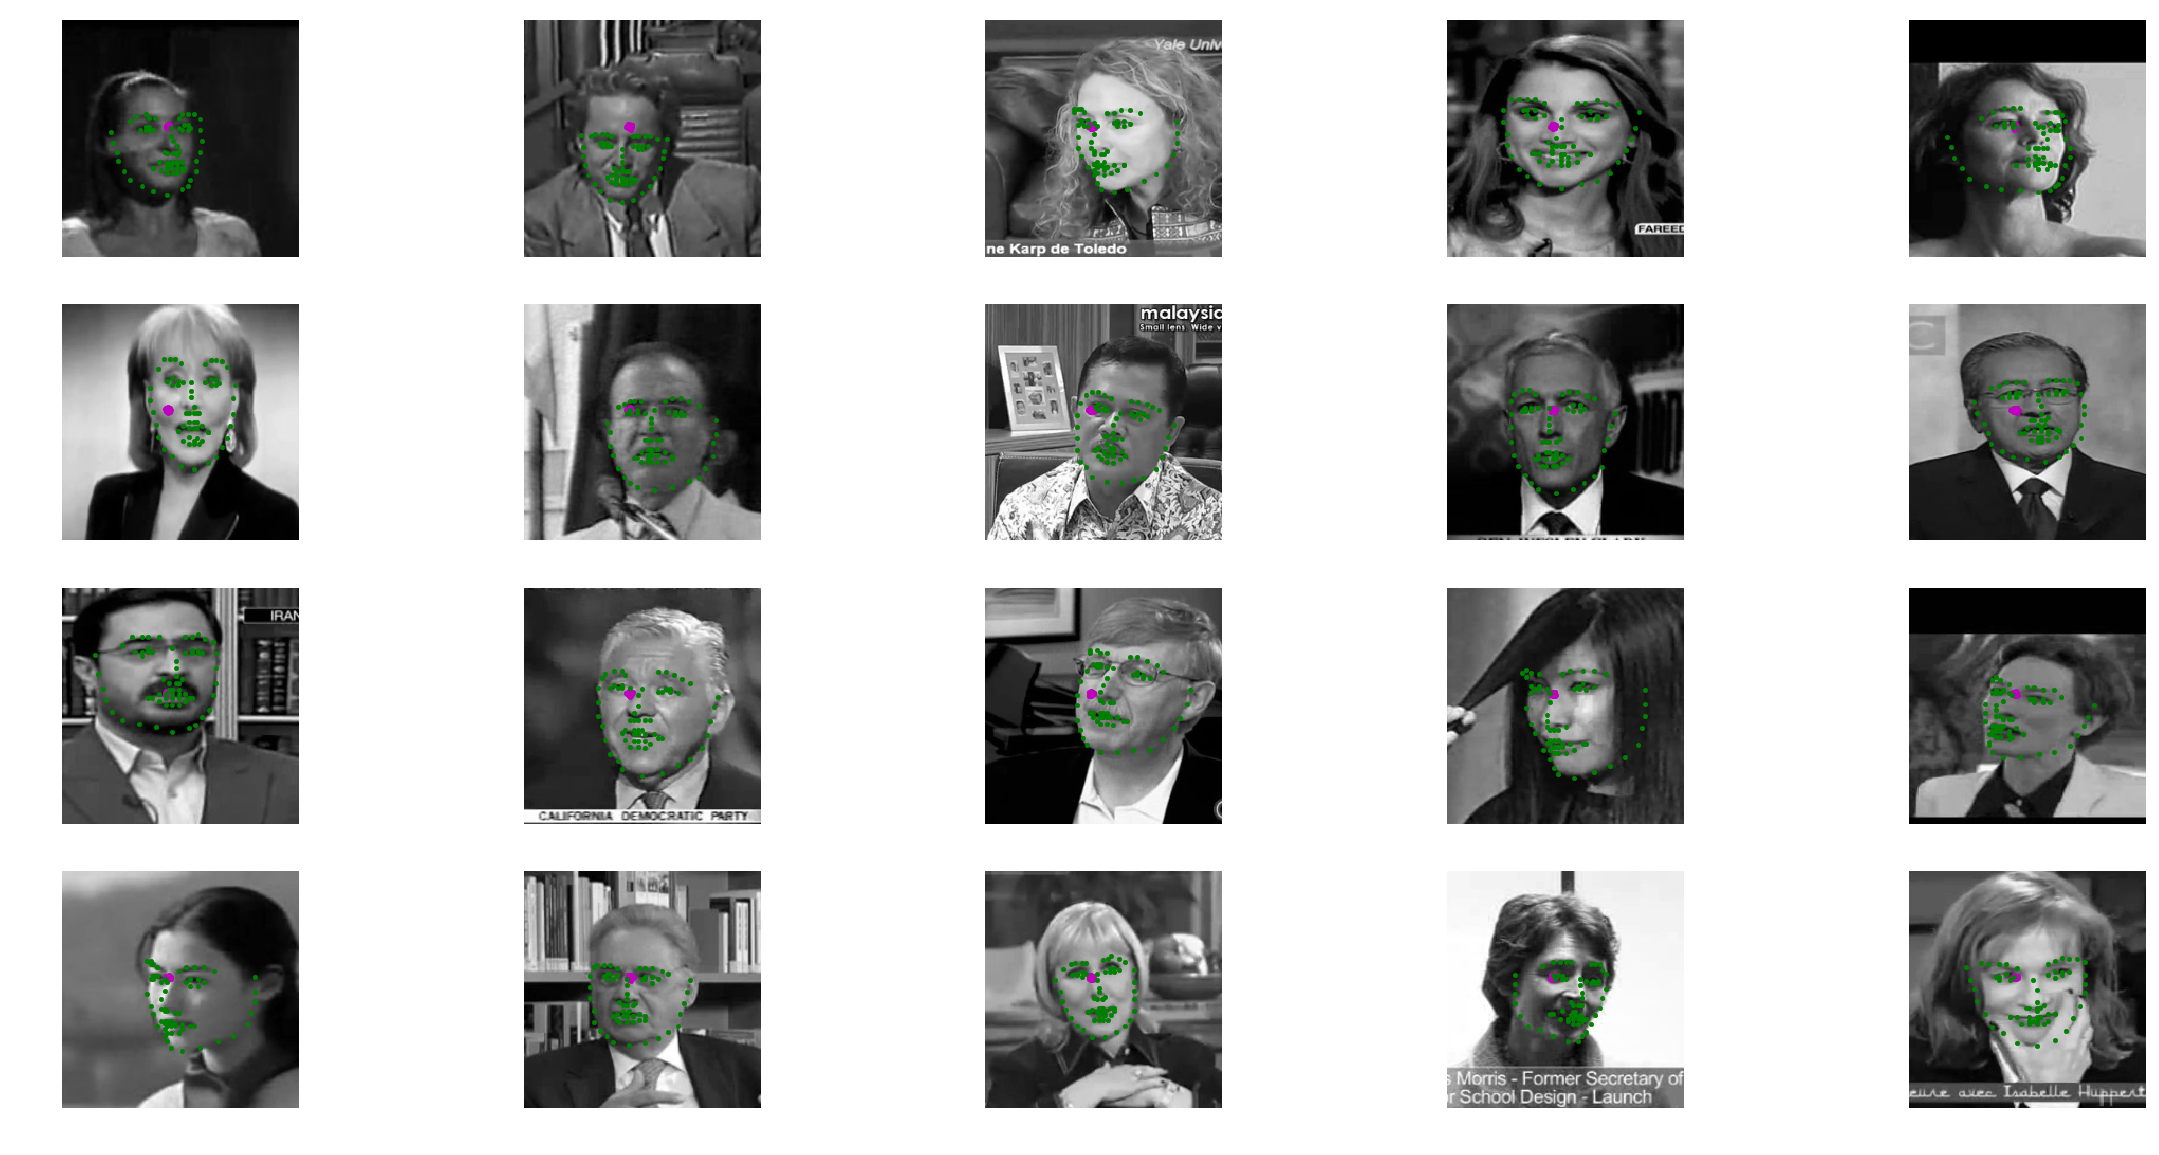

In [15]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    plt.figure(figsize=(20,10))
    plt.tight_layout()

    for i in range(batch_size):
        item_per_row = 5
        ax = plt.subplot(math.ceil(batch_size/item_per_row), item_per_row, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        
        if using_cuda:
            image = image.cpu().data.numpy()
        else:
            image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        if using_cuda:
            predicted_key_pts = predicted_key_pts.cpu().data.numpy()
        else:
            predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts, batch_size=test_batch_size)

## 训练

#### 损失函数
训练一个用于预测关键点的网络与训练一个用于预测类的网络不同。你可能希望选择适合回归的损失函数，而不是输出类的分布并使用交交叉熵损失函数，因为损失函数可以用于直接比较预测值和目标值。有关各种损失函数（如MSE或L1 / SmoothL1损失），请阅读 [本文档](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html)中的内容。

### TODO: 定义损失与优化

接下来，你需要通过定义损失函数和优化程序来定义模型的训练方式。

---

In [0]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)


## 训练与初步观察

现在，你要使用大量epoch，从`train_loader`中训练你的批量训练数据。

为了快速观察你的模型是如何训练并决定是否应该修改它的结构或超参数，我们建议你最开始的时候使用一个或两个epoch。训练时，请注意观察模型的损失会如何随着时间的推移而变化：例如，它会先快速减少然后再减慢吗？或者起初会在一段时间后出现减少？如果更改了训练数据的批量大小或修改损失函数，会发生什么变化？

在使用多个epoch进行训练并创建最终模型之前，使用这些初始观察值对模型进行更改并确定一个最佳架构。

In [0]:
def train_net(network, n_epochs):

    # prepare the net for training
    network.train()
    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        network.train()
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            if using_cuda:
                key_pts = key_pts.type(torch.cuda.FloatTensor)
                images = images.type(torch.cuda.FloatTensor)
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = network(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            history['train_loss'].append(loss)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
        network.eval()
        test_loss = 0.0
        steps = 0
        with torch.no_grad():
            for batch_i, data in enumerate(test_loader):
                images = data['image']
                key_pts = data['keypoints']
                key_pts = key_pts.view(key_pts.size(0), -1)
                if using_cuda:
                    key_pts = key_pts.type(torch.cuda.FloatTensor)
                    images = images.type(torch.cuda.FloatTensor)
                else:
                    key_pts = key_pts.type(torch.FloatTensor)
                    images = images.type(torch.FloatTensor)

                output_pts = network.forward(images)
                loss = criterion(output_pts, key_pts)
                test_loss += loss
                steps += 1
#             print('mem allocated:', torch.cuda.memory_allocated())
#             print('mem cached:', torch.cuda.memory_cached())
            test_loss /= steps
            history['test_loss'].append(test_loss)
            print('test loss:{:.4f}'.format(test_loss))
    print('Finished Training')
    return history


In [18]:
# train your network
n_epochs = 35 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
history = train_net(net, n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.1388056084513664
Epoch: 1, Batch: 20, Avg. Loss: 0.0637244537472725
Epoch: 1, Batch: 30, Avg. Loss: 0.0694245956838131
Epoch: 1, Batch: 40, Avg. Loss: 0.06533299684524536
Epoch: 1, Batch: 50, Avg. Loss: 0.06213527098298073
Epoch: 1, Batch: 60, Avg. Loss: 0.06761577501893043
Epoch: 1, Batch: 70, Avg. Loss: 0.05750305466353893
Epoch: 1, Batch: 80, Avg. Loss: 0.05979476533830166
Epoch: 1, Batch: 90, Avg. Loss: 0.05822022333741188
Epoch: 1, Batch: 100, Avg. Loss: 0.058809340372681616
Epoch: 1, Batch: 110, Avg. Loss: 0.06725099012255668
Epoch: 1, Batch: 120, Avg. Loss: 0.06849699690937996
Epoch: 1, Batch: 130, Avg. Loss: 0.05854803770780563
Epoch: 1, Batch: 140, Avg. Loss: 0.061035243421792985
Epoch: 1, Batch: 150, Avg. Loss: 0.0648194219917059
Epoch: 1, Batch: 160, Avg. Loss: 0.07174688465893268
Epoch: 1, Batch: 170, Avg. Loss: 0.06520364806056023
test loss:0.0524
Epoch: 2, Batch: 10, Avg. Loss: 0.06999192014336586
Epoch: 2, Batch: 20, Avg. Loss: 0.0655170

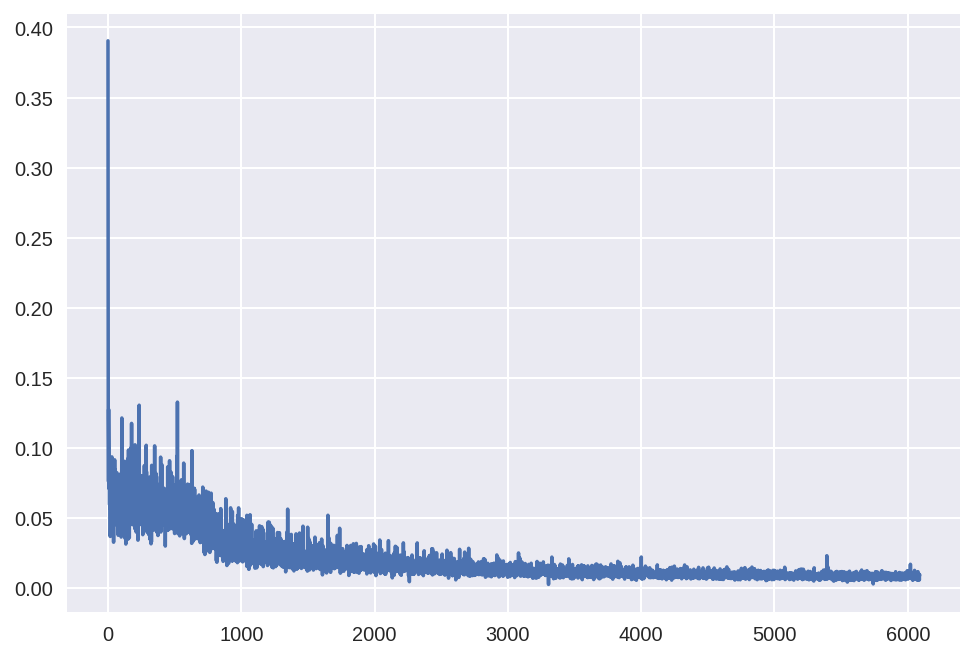

In [19]:
plt.plot(history['train_loss'])

(0, 35)

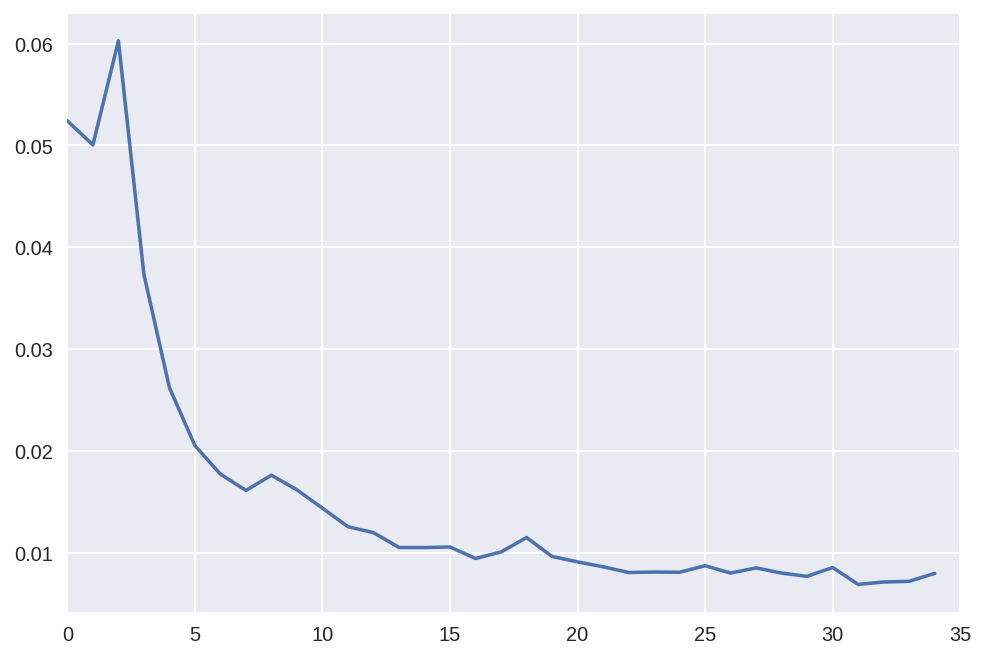

In [20]:
plt.plot(history['test_loss'])
plt.xlim(0, n_epochs)

## 测试数据

了解你的模型在之前未见过的测试数据上的表现如何。我们已经对测试数据进行加载与转换，这一点类似于与训练数据时的做法类似。接下来，在这些图像上运行已被训练的模型，查看其生成的关键点类型。你应该能够观察到你的模型是否拟合了它看到的每个新人脸，这些点是否是随机分布的，以及这些点实际上是否过度拟合了训练数据而没有进行归纳。

In [21]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

images.shape torch.Size([20, 1, 224, 224])
torch.Size([20, 136])
torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


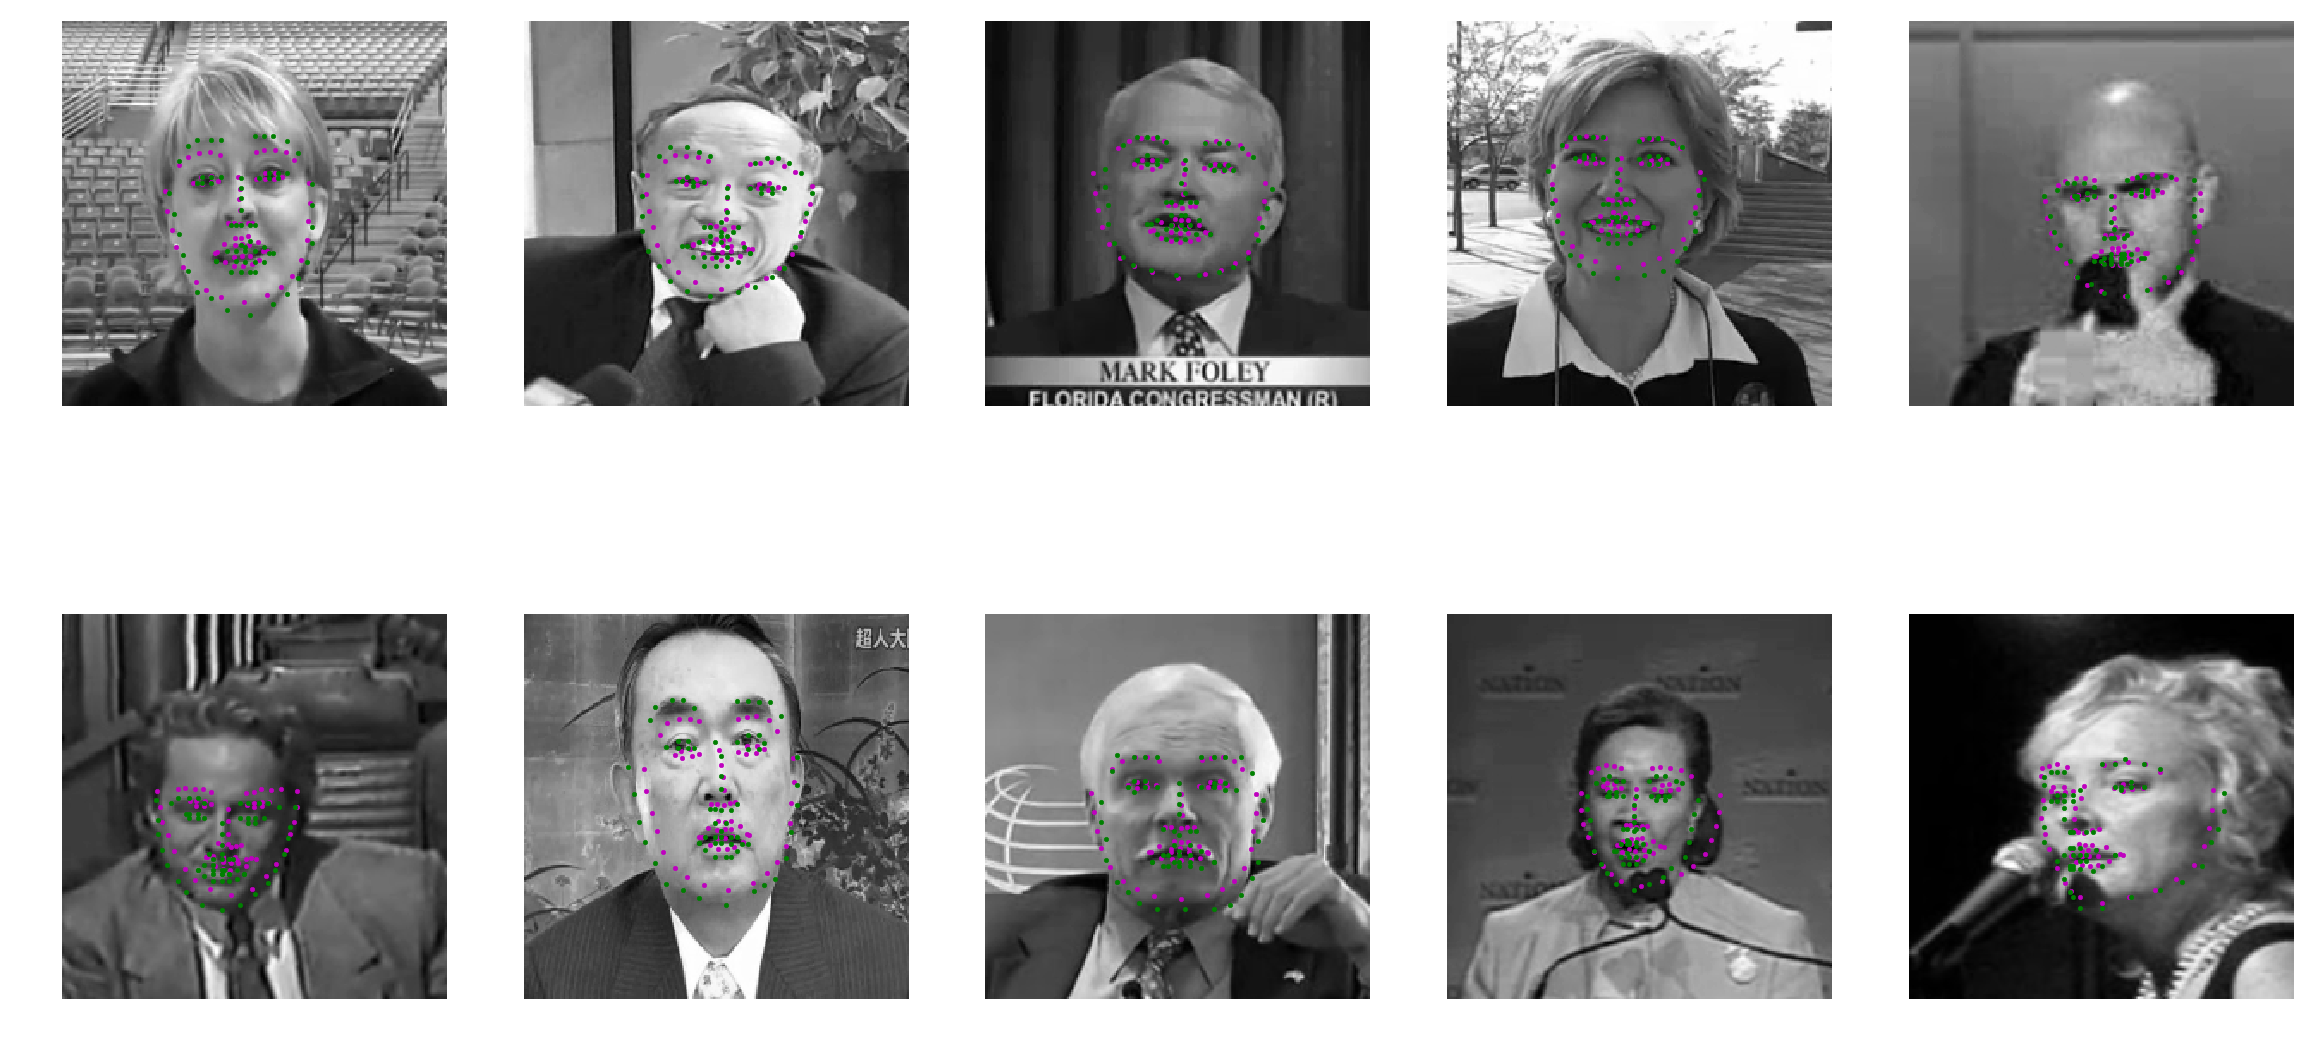

In [22]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


找到了一个或两个表现良好的模型后，保存你的模型，这样你就可以加载它并在以后使用它了！

在这里，你需要保存模型，但请**在提交项目之前删除任何检查点和已保存的模型**，否则你的工作区可能会因为太大而无法提交。

In [0]:
## TODO: change the name to something uniqe for each new model
!mkdir saved_models
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [24]:
!ls -lh saved_models/

total 4.2M
-rw-r--r-- 1 root root 4.2M Apr  9 12:53 keypoints_model_1.pt


完成对一个表现良好的模型的训练后，请回答以下问题，以便我们对你的训练和架构选择过程有一些了解。要通过此项目，你需要回答下列所有问题。

### 问题1：你选择了哪些优化和损失函数？为什么会这样选择？


**答案**: 
1. 优化函数选择了`Adam`，这个优化函数可以使网络快速收敛；
2. 选择了`MSE`作为损失函数，由于预测目标是坐标值，属于连续数值类型，使用均方误差可以很有效地度量预测值和真实标签之间的差异。

### 问题2：最开始，你的网络架构是什么样的？在尝试不同的架构时，又做了怎样的修改？为避免过度拟合数据，你是否决定添加了更多卷积层或其他层？

**答案**: 
最开始的架构是：`Conv1(32)==>Conv2(64)`，架构较为简单，随着训练中学习曲线体现的拟合程度变化情况，当模型没办法在提升`Epoch`和优化器等超参数条件下继续减小`loss`时，逐渐加入更多的卷积层，提高拟合度，同时，在最后的全连接层加入`Dropout`层，避免过拟合；

### 问题3：你是如何决定训练模型的epoch数量和batch_size的？

**答案**: 
1. `epoch`的数量可以根据学习曲线来确定，在学习曲线中，包括训练`loss`和测试`loss`的曲线，在模型训练过程中，欠拟合模型的两条损失函数曲线最终不会达到理想的最小值；而过拟合的`loss`曲线中，训练曲线会越来越小，但是测试曲线会在减小后又增大；理想的模型在训练过程中，两个`loss`曲线都会逐渐下降到一个较为理想的值。此时固定住`epoch`。在实际训练过程中，测试曲线没有出现过减小后又逐渐增大的情况，可能是因为使用了`Dropout`层，使模型复杂度增加时也不至于过拟合。`batch_size`可以先初始化一个较小值，并逐渐增大，看学习曲线是否会出现震荡或者收敛更快，选择使模型平滑变化且下降快的的值。

## 特征可视化

有时，神经网络会被当做是一个黑盒子，给定一些输入，它就会学习产生一些输出。 事实上，CNN正在学习识别各种空间模式，你可以通过查看构成每个卷积核的权重并将这些一次性应用于样本图像来可视化每个卷积层已被训练识别的内容。这种技术称为特征可视化，它对于理解CNN的内部工作方式很有帮助。

在下面的单元格中，你可以看到如何从第一个卷积层中按索引提取单个滤波器。滤波器应显示为灰度网格。

[[ 0.20300418  0.08839177 -0.16113034]
 [ 0.17809258  0.31675214 -0.19110079]
 [-0.15642115 -0.13080898  0.07790282]]
(3, 3)


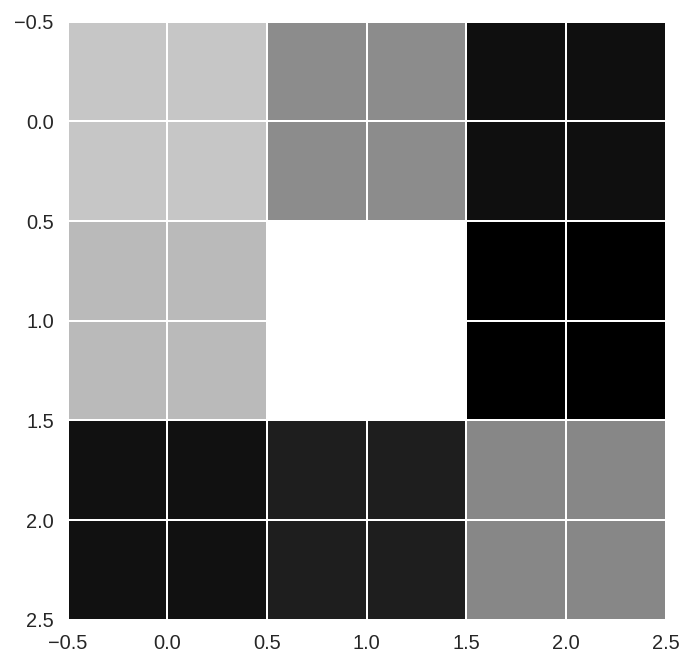

In [25]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

if using_cuda:
    w = weights1.cpu().data.numpy()
else:
    w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## 特征映射

每个CNN至少包含一个由堆叠滤波器（也称为卷积核）组成的卷积层。CNN在进行训练时，它要学习在卷积内核中包含哪些权重，当这些内核应用于某些输入图像时，它们会产生一组**特征映射**。因此，特征映射只是过滤图像的集合，它们是通过将卷积核应用于输入图像而产生的图像。这些映射向我们展示了神经网络不同层学习提取的特征。例如，你可以想象一个卷积内核，它可以检测到脸部的垂直边缘，而另一个可以检测到眼角的边缘。通过将这些内核应用于图像，你可以看到每个内核检测到了哪些特征。具体请看以下示例，从它在图像中显示线条的方式，你可以将其表征为边缘检测滤波。

<img src='images/feature_map_ex.png' width=50% height=50%/>


接下来，选择一个测试图像并使用已被训练的CNN中的一个卷积内核对其进行过滤。查看过滤后的输出，了解该内核检测到的内容。

### TODO: 过滤图像，查看卷积内核的效果
---

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, 'original image')

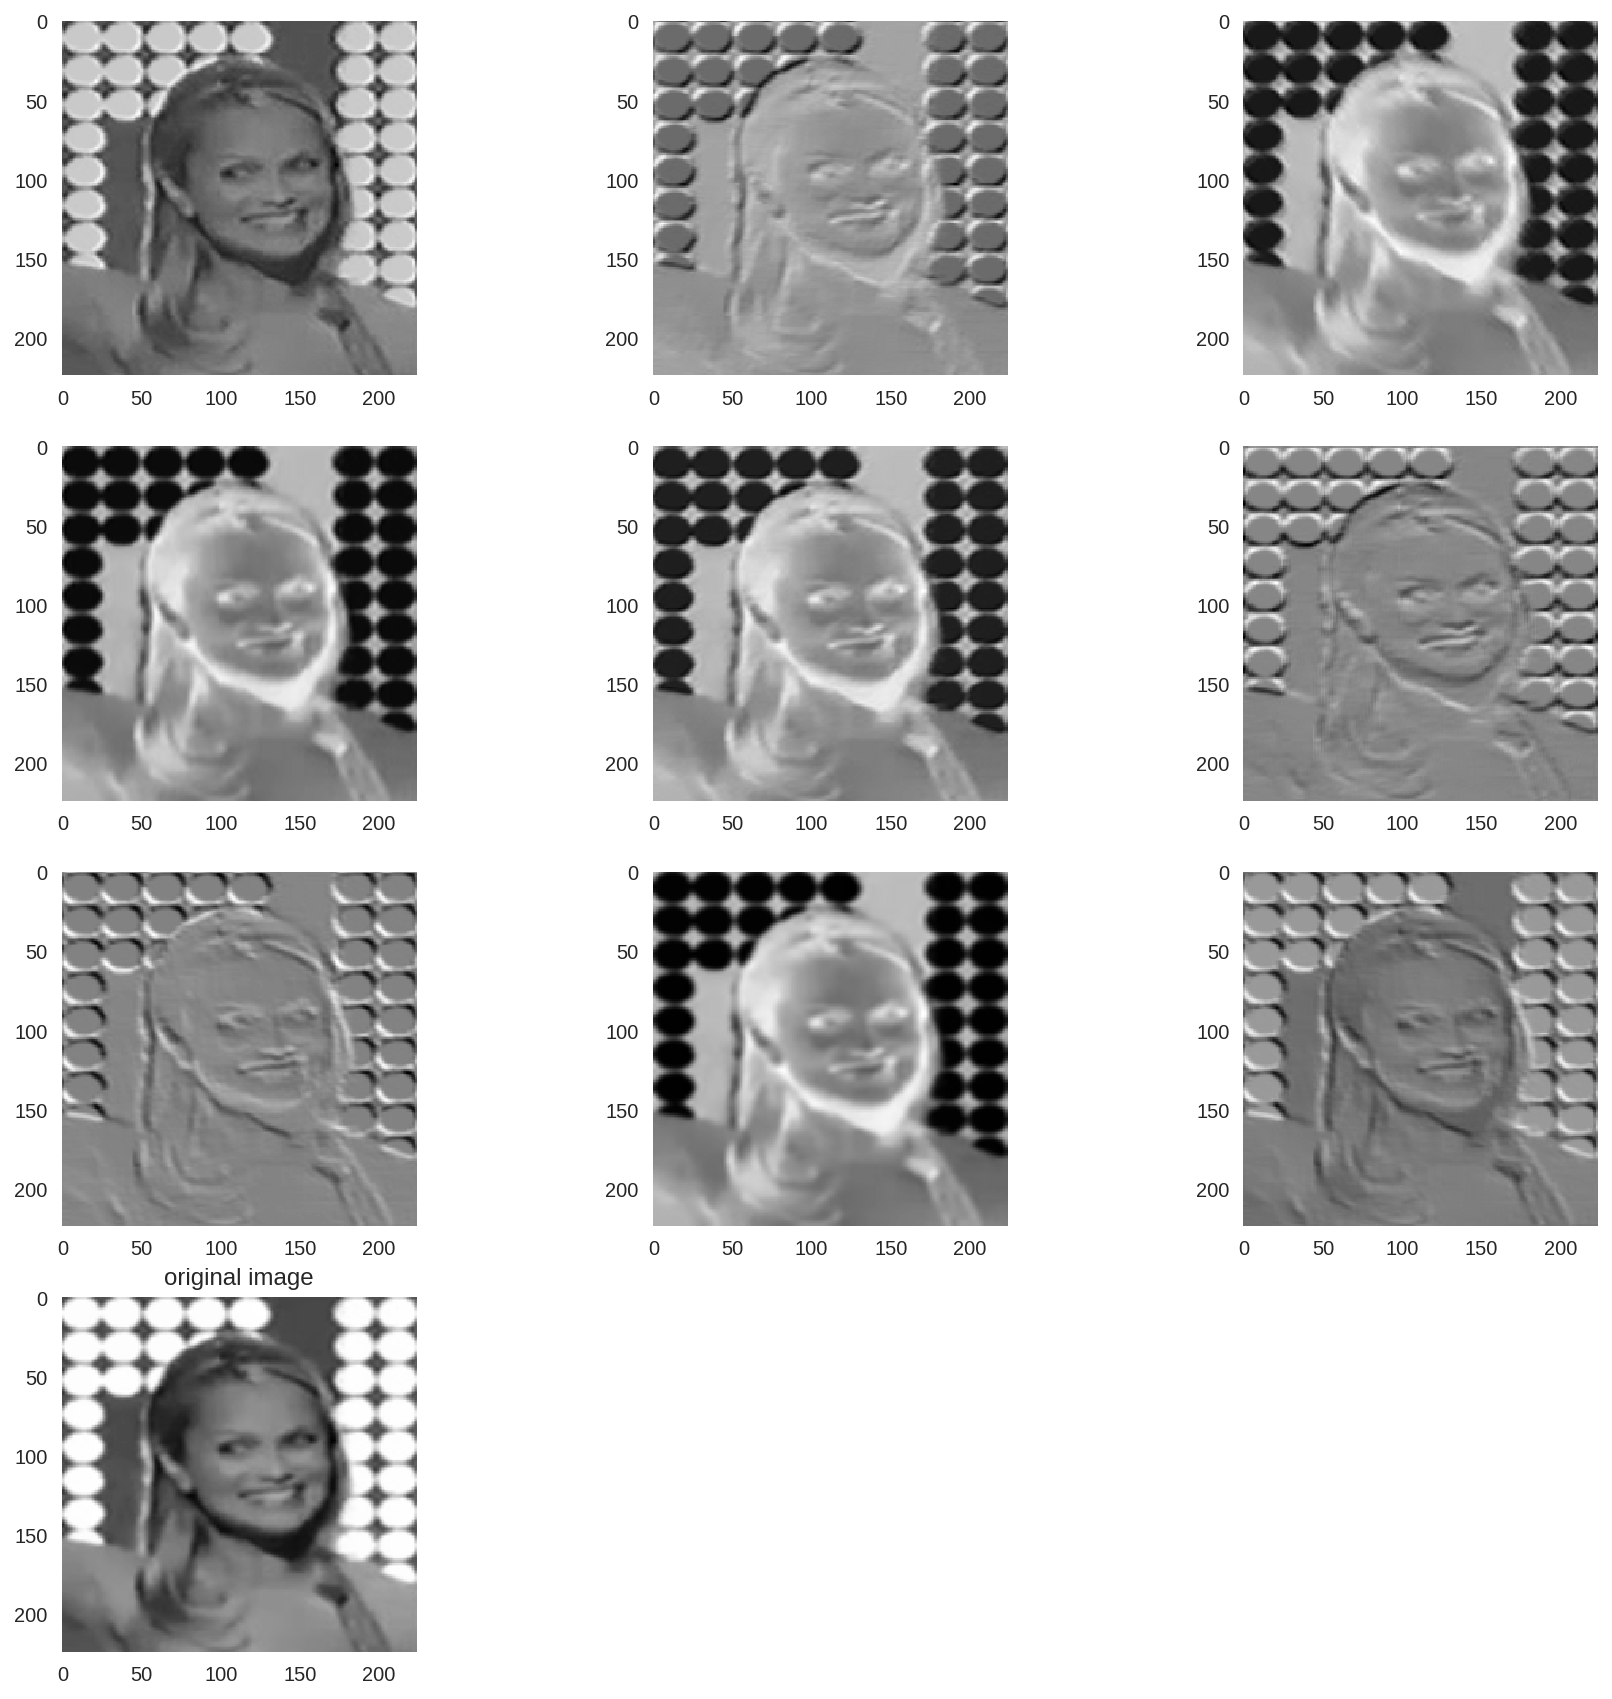

In [26]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

def filter_and_show_img(f, img):
    img_new = cv2.filter2D(img, -1, f)
    plt.grid(False)
    plt.imshow(img_new, cmap='gray')

sample_datas = next(iter(test_loader))
sample = sample_datas

plt.figure(figsize=(15, 15))
plt.tight_layout(pad=0.1, w_pad=0, h_pad=1.0)

img_per_row = 3
filters_count = 9 + 1
img_index = 3

for i in range(filters_count):
    img = sample['image'][img_index].cpu().data.numpy().reshape(224, 224)
    ax = plt.subplot(math.ceil(filters_count/img_per_row), img_per_row, i+1)
    filter_and_show_img(w[i][0], img)
ax = plt.subplot(math.ceil(filters_count/img_per_row), img_per_row, filters_count)
plt.imshow(sample['image'][img_index].cpu().data.numpy().reshape(224, 224), cmap='gray')
plt.title('original image')

## 问题4：从已被训练的CNN中选择一个滤波器并将其应用于测试图像。你认为它会起到什么作用？你认为它会检测到哪种特征？


**答案**:它检测到的是垂直线条还是模糊噪音等？请在这里写下你的答案

---
## 继续加油吧！

现在，你已经定义并训练了模型，最终也保存了一个最佳模型。接下来，就是最后一个notebook，它会将人脸检测器与你保存的模型相结合，创建一个人脸关键点检测系统，用于预测一种图像中*任何一个* 人脸的关键点！